In [1]:
%matplotlib inline

import os
import json
from glob import glob
from collections import defaultdict

import dinopy
import yaml
import matplotlib.pyplot as plt
import seaborn
import numpy
import pandas as pd
import networkx
from scipy.special import binom
from IPython.display import Image, display

from phasm.io import gfa
from phasm.alignments import AlignmentType
from phasm.assembly_graph import AssemblyGraph
from phasm.bubbles import find_superbubbles

BASE_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))

with open(os.path.join(BASE_DIR, "config.yml")) as f:
    config = yaml.load(f)
    
seaborn.set_context('paper')
seaborn.set_style('whitegrid')

In [2]:
spanning_read_stats = []
candidate_prob_stats = []
exact_num_candidates_stats = []
for assembly, asm_config in config['assemblies'].items():
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    asm_folder = os.path.join(BASE_DIR, "assemblies", assembly)
    
    for debugdata in glob("{}/04_phase/component[0-9].bubblechain[0-9]-debugdata.json".format(asm_folder)):
        print(debugdata)
        graphml = debugdata.replace("-debugdata.json", ".graphml").replace("04_phase", "03_chain")
        g = AssemblyGraph(networkx.read_graphml(graphml))
        
        bubbles = dict(find_superbubbles(g, report_nested=False))
        bubble_entrances = set(bubbles.keys())
        
        curr_bubble = None
        bubble_num = 0
        num_candidates = -1
        with open(debugdata) as f:
            for line in f:
                data = json.loads(line)
                if data['type'] == "new_bubble":
                    curr_bubble = data
                    num_paths = len(list(networkx.all_simple_paths(g, data['entrance'], data['exit'])))
                    
                    if data['start_of_block'] == True:
                        bubble_num = 1
                        num_candidates = binom(ploidy + num_paths - 1,
-                                              ploidy)
                        exact_num_candidates_stats.append({
                            'ploidy': ploidy,
                            'coverage': coverage,
                            'bubble_num': bubble_num,
                            'num_candidates': num_candidates
                        })
                    else:
                        dist_between_bubbles = (
                            min(e[2] for e in g.out_edges_iter(data['entrance'], data=g.edge_len))
                        )
                        spanning_read_stats.append({
                            'dist': dist_between_bubbles,
                            'spanning_reads': len(data['rel_read_info']),
                            'ploidy': ploidy
                        })
                        
                        bubble_num += 1
                        num_candidates *= num_paths**ploidy
                        
                        exact_num_candidates_stats.append({
                            'ploidy': ploidy,
                            'coverage': coverage,
                            'bubble_num': bubble_num,
                            'num_candidates': num_candidates
                        })
                
                if data['type'] == "candidate_set":
                    p_sr = data['p_sr']
                    prior = data['prior']
                    prob = 10**(p_sr + prior)
                    entrance = curr_bubble['entrance']
                    exit = curr_bubble['exit']
                    candidate_prob_stats.append({
                        'bubble': (entrance, exit),
                        'bubble_num': bubble_num,
                        'candidate_prob': prob,
                        'ploidy': ploidy,
                        'coverage': coverage
                    })

/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-60x-error-free/04_phase/component0.bubblechain0-debugdata.json
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-60x-error-free/04_phase/component1.bubblechain0-debugdata.json
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy3-60x-error-free/04_phase/component0.bubblechain0-debugdata.json
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy3-60x-error-free/04_phase/component1.bubblechain0-debugdata.json
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy6-60x-error-free/04_phase/component0.bubblechain0-debugdata.json
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy6-60x-error-free/04_phase/component1.bubblechain0-debugdata.json


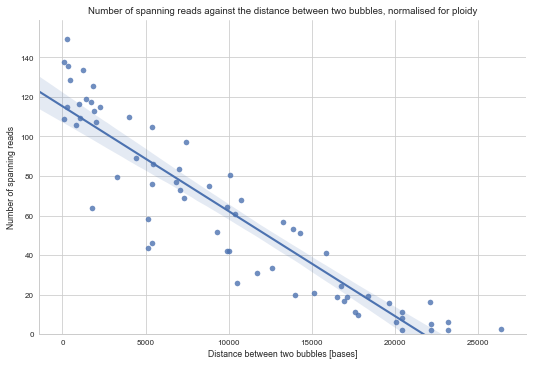

In [5]:
srdf = pd.DataFrame(spanning_read_stats)
srdf['spanning_reads_norm'] = srdf['spanning_reads'] / srdf['ploidy']
seaborn.lmplot(x="dist", y="spanning_reads_norm", data=srdf, size=5, aspect=1.5)
plt.title("Number of spanning reads against the distance between two bubbles, normalised for ploidy")
plt.ylim(ymin=0)
plt.xlabel("Distance between two bubbles [bases]")
plt.ylabel("Number of spanning reads")
plt.savefig(os.path.join(BASE_DIR, 'figures', 'spanning-reads.png'), transparent=True, dpi=256)


(-0.023326449246147171, 1.0)

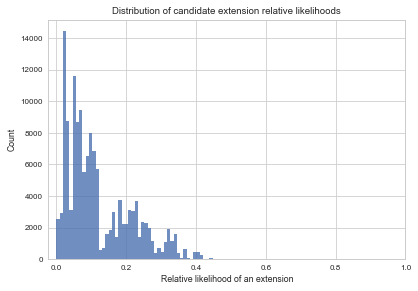

In [15]:
candidate_df = pd.DataFrame(candidate_prob_stats)
candidate_df.set_index('bubble')
plt.figure()
seaborn.distplot(candidate_df['candidate_prob'], kde=False, hist_kws={"alpha": 0.8})
plt.title("Distribution of candidate extension relative likelihoods")
plt.xlabel("Relative likelihood of an extension")
plt.ylabel("Count")
plt.xlim(xmax=1.0)

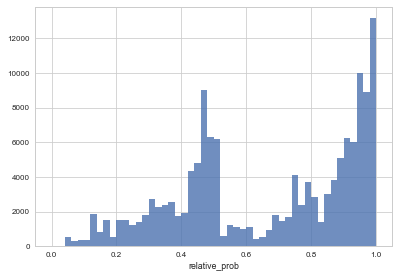

In [31]:
grouped = candidate_df.groupby(['bubble', 'ploidy'])['candidate_prob']
max_probs = grouped.max()

for bubble, ploidy in grouped.groups.keys():
    candidate_df.loc[grouped.groups[bubble, ploidy], 'max_prob'] = max_probs[bubble, ploidy]
    
candidate_df['relative_prob'] = candidate_df['candidate_prob'] / candidate_df['max_prob']
candidate_df

plt.figure()
seaborn.distplot(candidate_df['relative_prob'], kde=False, hist_kws={"alpha": 0.8})